In [1]:
import pandas as pd
import xgboost as xgb

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('PJME_hourly.csv')

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df.shape

(145366, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [6]:
df.Datetime = pd.to_datetime(df['Datetime'])
df.columns

Index(['Datetime', 'PJME_MW'], dtype='object')

In [7]:
df = df.set_index('Datetime')
df.columns

Index(['PJME_MW'], dtype='object')

In [8]:
col_pal = sns.color_palette()

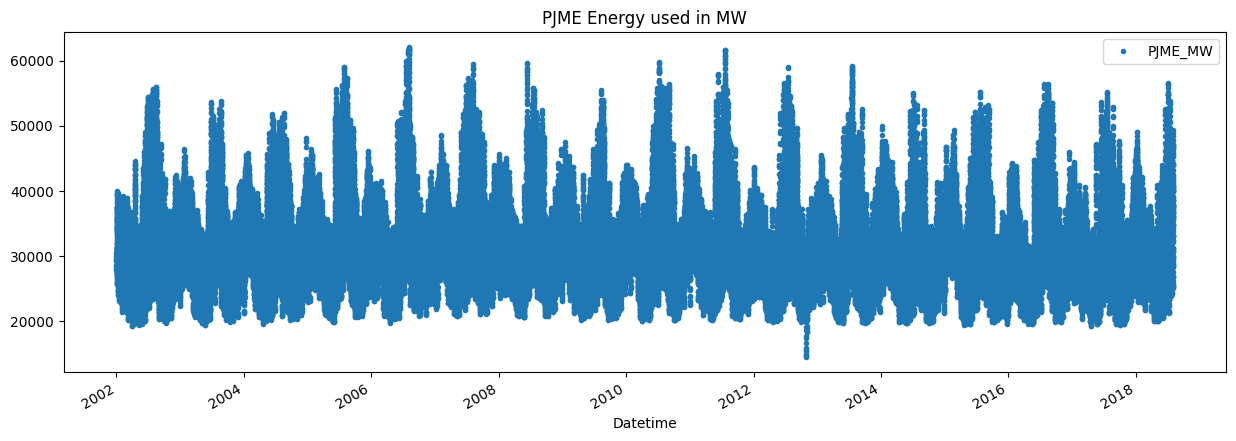

In [9]:
df.plot(style='.', figsize=(15,5), color=col_pal[0], title="PJME Energy used in MW")
plt.show()

In [10]:
## Split the training and test data set...before 2015 , split as training data and after 2015, use as test data
df_train = df.loc[df.index < '01-01-2015']
df_test = df.loc[df.index > '01-01-2015']
df_train.columns


Index(['PJME_MW'], dtype='object')

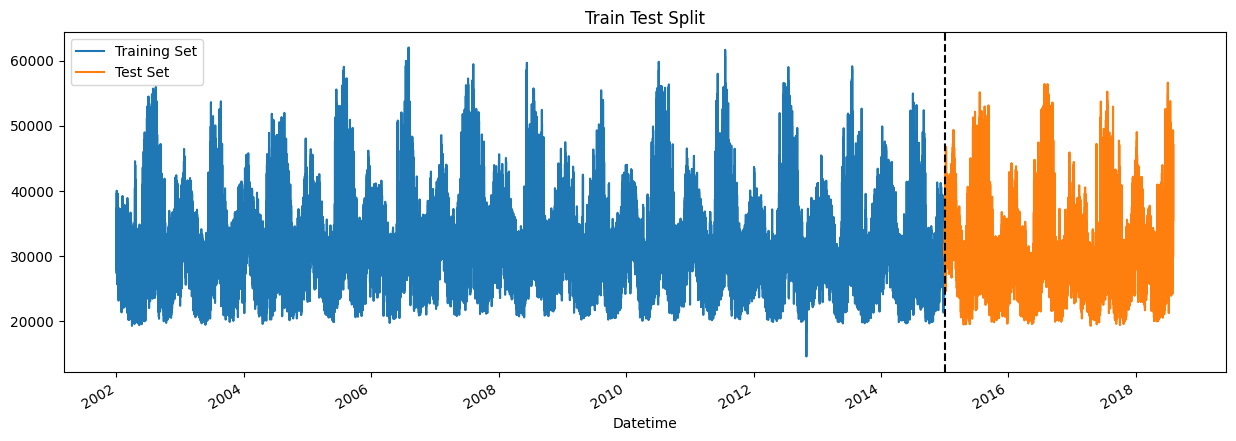

In [11]:
fig, ax = plt.subplots(figsize=(15,5), )
df_train.plot(ax=ax, label = 'Train Set', title='Train Test Split')
df_test.plot(ax=ax, label= 'Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()



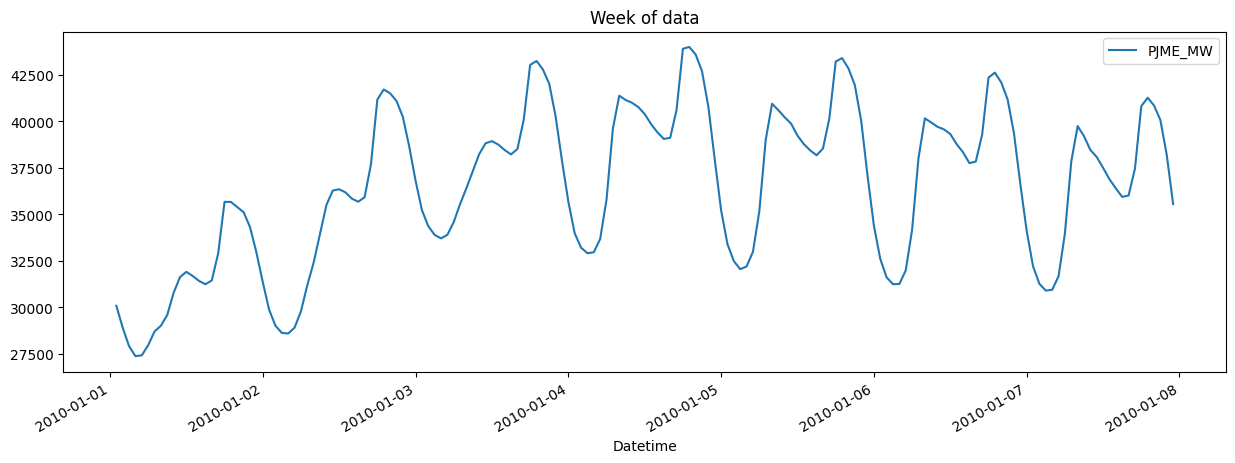

In [12]:
df.loc[(df.index>'01-01-2010') & (df.index<'01-08-2010')].plot(figsize=(15,5), title ='Week of data')
plt.show()

## Feature Creation

In [13]:
# Add features to the dataset , Create time series features based on time series index
def create_features(df):
    """
    """
    df = df.copy()
    df['hour']=df.index.hour
    df['day_of_week']=df.index.day_of_week
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    return df    
    
    

In [14]:
df=create_features(df)
df.head()

,PJME_MW,hour,day_of_week,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


## Visualize feature / target Relationship

C:\Users\virup\AppData\Local\Temp\ipykernel_15836\333359881.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Blues')


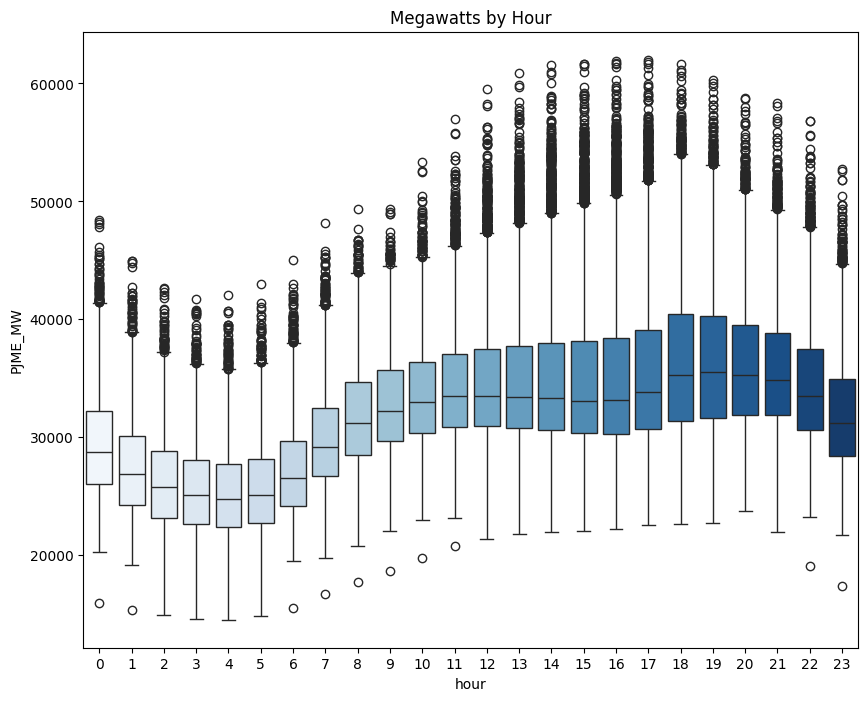

In [15]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Blues')
ax.set_title('Megawatts by Hour')
plt.show()

### Energy consumption is more during daytime , afternoon onwards , low during night

C:\Users\virup\AppData\Local\Temp\ipykernel_15836\1249999865.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


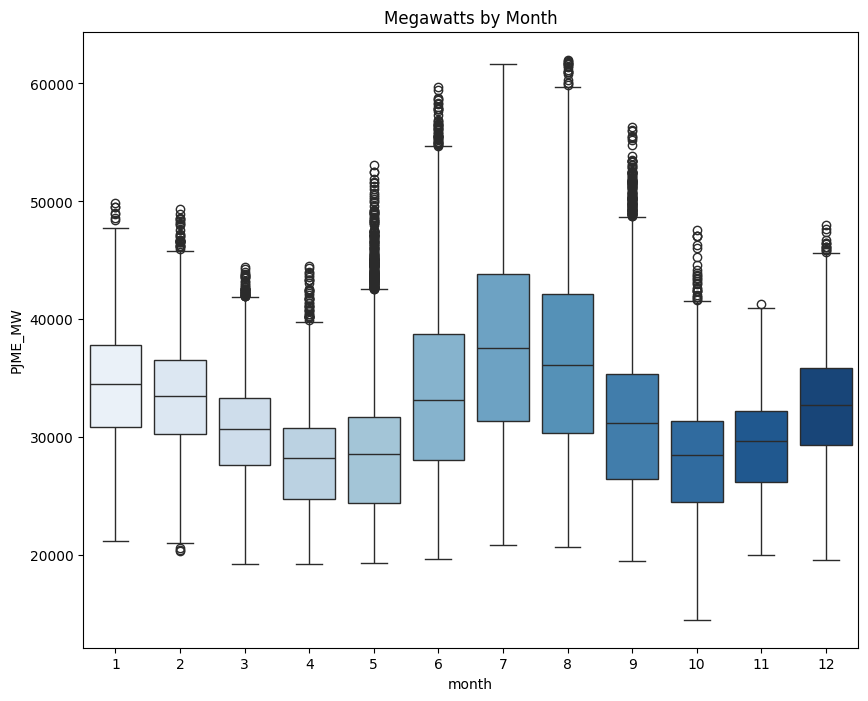

In [16]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('Megawatts by Month')
plt.show()

### So, energy consumption is more in winter and then in summer

## Create a Model

In [17]:
train = create_features(df_train)
test = create_features(df_test)

In [18]:
train.columns

Index(['PJME_MW', 'hour', 'day_of_week', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [22]:
X_features = ["hour",  "day_of_week", "quarter", "month","year", "dayofyear"]
X_train = train[X_features]
y_train = train["PJME_MW"]
X_test = test[X_features]
y_test = test["PJME_MW"]
#lower the learning rate to 0.01 so that it doesn't overfit early.
#verbose = 100 instaed of True, so that it will print every 100 trees that are built
model = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50, learning_rate=0.01)
model.fit (X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.91863
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.09901
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.62326
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.82401
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.99223
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.31981


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Feature Importance

In [23]:
model.feature_importances_

array([0.46387812, 0.1620048 , 0.02888114, 0.20316096, 0.02382433,
       0.11825063], dtype=float32)

In [27]:
FI = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_, columns = ['Importances'])

<Axes: title={'center': 'feature_importance'}>

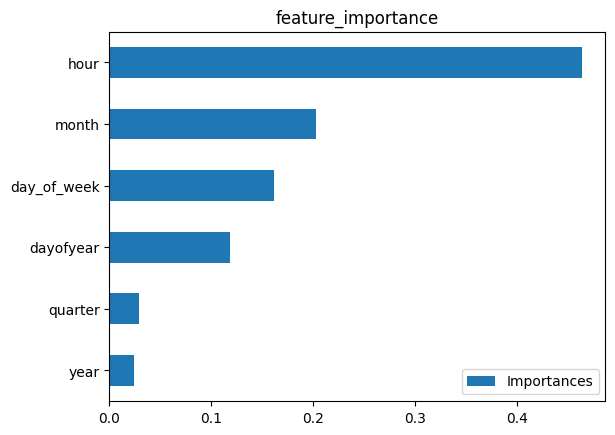

In [28]:
FI.sort_values('Importances').plot(kind='barh', title='feature_importance')

### Forecast On Test

In [30]:
test['prediction']=model.predict(X_test)

In [31]:
df = df.merge(test[['prediction']], how="left", left_index=True, right_index=True)

In [32]:
df.head()

,PJME_MW,hour,day_of_week,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN


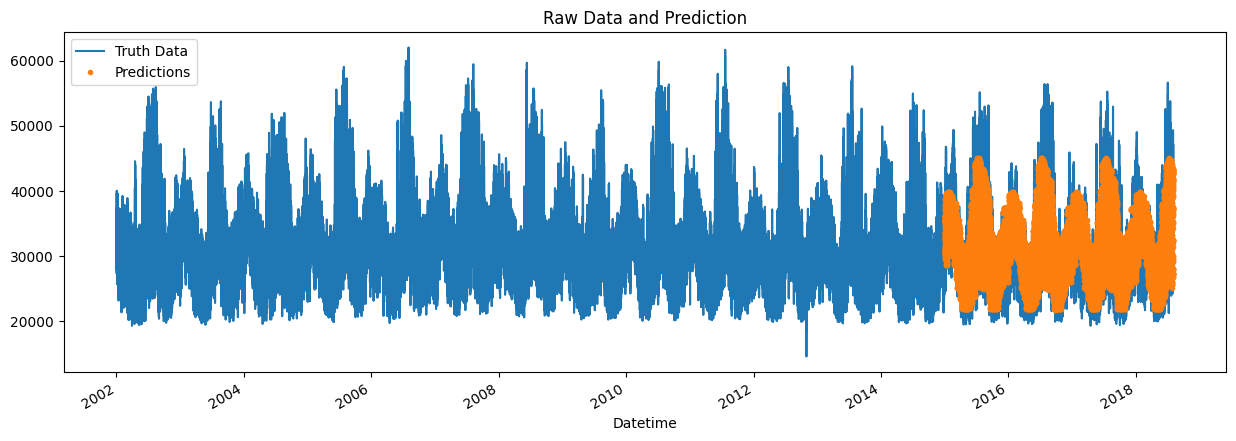

In [38]:
ax= df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

### Plot week's data

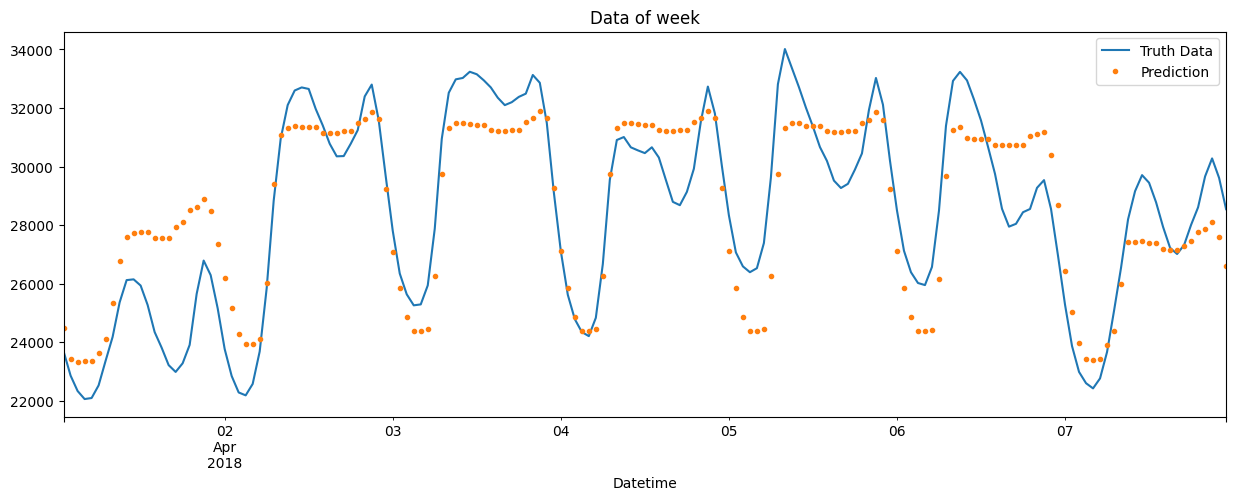

In [39]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15,5), title='Data of week')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')

plt.legend(['Truth Data', 'Prediction'])
plt.show()

### Calculate RMSE

In [42]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print (f'RMSE Score on Test Set : {score: 0.2f}')

RMSE Score on Test Set :  3741.09


### Calculate Error 

In [43]:
test['Error'] = np.abs(test['prediction']-test['PJME_MW'])

In [44]:
test['date']= test.index.date

In [48]:
test.groupby('date')['Error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: Error, dtype: float64

In [49]:
test.groupby('date')['Error'].mean().sort_values(ascending=False).tail(5)

date
2017-05-02    453.738688
2016-04-04    440.223877
2016-10-27    440.053141
2017-10-24    413.885824
2016-12-30    395.436442
Name: Error, dtype: float64

In [ ]:
#Next steps 
# Use cross validation 
# add more features (weather forescase, holidays )